Topic Modeling
============



```{admonition} Learning Objectives
By the end of this chapter, you will be able to:

+ Explain what a topic model is, what it represents, and how to use one to explore a corpus
+ Build a topic model
+ Appraise the validity of a topic model and fine tune it accordingly
```

Preliminiaries
----------------

As before, we'll use a file manifest to keep things orderly.

In [1]:
import pandas as pd

manifest = pd.read_csv("data/session_three/manifest.csv", index_col = 0)
manifest['PUB_DATE'] = pd.to_datetime(manifest['PUB_DATE'], format="%Y-%m-%d")

print(
    f"Number of blurbs: {len(manifest)}",
    f"\nDate range: {manifest['PUB_DATE'].dt.year.min()}--{manifest['PUB_DATE'].dt.year.max()}",
    f"\nGenres: {', '.join(manifest['GENRE'].unique().tolist())}"
)

manifest.sample(5)

Number of blurbs: 1500 
Date range: 1958--2018 
Genres: Fiction, Classics, Nonfiction, Children’s Books, Teen & Young Adult, Poetry, Humor


,AUTHOR,TITLE,GENRE,PUB_DATE,ISBN,FILE_NAME
174,Patricia Briggs,The Hob's Bargain,Fiction,2001-03-01,9780441008131,0174.txt
1247,DK,The Sherlock Holmes Book,Classics,2015-10-20,9781465438492,1247.txt
1040,Bryan D. Palmer,E.P. Thompson,Nonfiction,1994-10-17,9781859840702,1040.txt
824,Robert B. Parker,Pale Kings and Princes,Fiction,1988-06-10,9780440200048,0824.txt
925,Penelope Lively,The Purple Swamp Hen and Other Stories,Fiction,2018-05-08,9780735222052,0925.txt


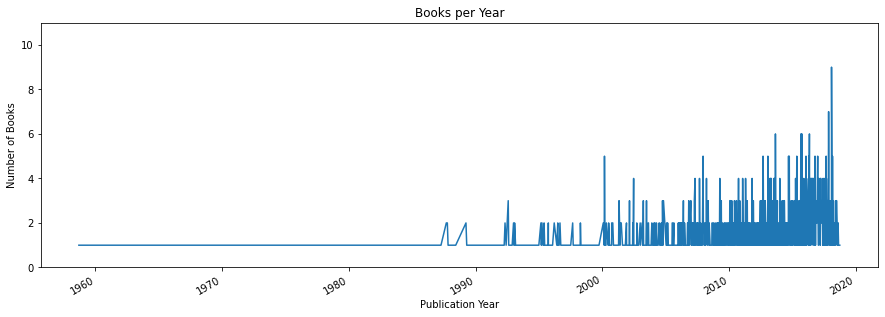

In [2]:
manifest.groupby('PUB_DATE')['ISBN'].count().plot(figsize = (15, 5),
                                                  title = "Books per Year",
                                                  xlabel = "Publication Year",
                                                  ylabel = "Number of Books",
                                                  ylim = (0, 11)
                                                  );

To make file loading easier, we'll isolate the file names from `manifest` and create a list of paths.

In [3]:
indir = "data/session_three/input/"
paths = indir + manifest['FILE_NAME']

Building a Topic Model
---------------------------

With this bit of preliminary work done, we're ready to build a topic model. There are numerous implementations of 
LDA modeling available, ranging from the command line utility, [MALLET] (which many of us in the DataLab use in our 
own work), to built-in APIs offered by both `gensim` and `scikit-learn`. It's tempting to use the `scikit-learn` 
API: we should be familiar with this package's conventions by now, and indeed it's quite easy to spin up a topic 
model using its API. But there's a [reported bug] in a key metric for validating LDA models in `scikit-learn`, and, 
as far as we know, this bug hasn't been fixed. Depending on your use case, this may not be a big deal. The bug has 
to do with generating a **perplexity score** from the model, which is useful for fine tuning. You, however, may not 
want to go through this process, especially if you're working in an exploratory model. In this case, it's probably 
fine to use `scikit-learn`.

As for us: we'll be demonstrating how to fine tune models and will thus avoid `scikit-learn` for the workshop. 
Instead, we'll be using `tomotopy`, a Python wrapper built around Tomato, a topic modeling tool built in C++. Its 
API is fairly intuitive and comes with lots of options, which we'll leverage to build the best model possible for 
our data.

[MALLET]: https://mimno.github.io/Mallet/
[reported bug]: https://github.com/scikit-learn/scikit-learn/issues/6777

### Initializing a model

Initializing a topic model with `tomotopy` is simple: just assign `LDAModel()` to a variable and declare the number 
of topics the model will generate. As we'll discuss below, determining how many topics to use is a matter of some 
debate and complexity, but for now, we'll just pick a number and move ahead.

In [4]:
import tomotopy as tp

n_topics = 5
model = tp.LDAModel(k = n_topics, seed = 357)

Now we need to add our blurbs to the model. We'll do so by using a `for` loop in conjunction with all the paths we 
created above. The only catch here is that we need to split each blurb into a list of tokens (right now they're 
stored as text blobs).

In [5]:
for path in paths:
    with open(path, 'r') as p:
        doc = p.read().split()
        model.add_doc(doc)
        
print("Number of documents:", len(model.docs))

Number of documents: 1500


### Training a model

Our model is now ready to be trained. Under the hood, this happens in an iterative fashion, so we need to set the 
total number of iterations we'd like to use to do the training. With that set, it's simply a matter of calling 
`model.train()`.

In [6]:
n_iters = 500
model.train(iter = n_iters)

### Inspecting the Results

With our trained on our corpus, we can access some high-level information about the corpus.

In [7]:
print(
    f"Number of unique words: {len(model.used_vocabs)}",
    f"\nTotal number of tokens: {model.num_words}"
)

Number of unique words: 19609 
Total number of tokens: 129027


For each topic, we can get the words most associated with that topic. The accompanying score is the probability of 
that word appearing in a given topic.

In [8]:
for k in range(model.k):
    top_words = model.get_topic_words(topic_id = k, top_n = 5)
    top_words = [f"{tup[0]} ({tup[1]:.04f}%)" for tup in top_words]
    print(
        f"Topic {k}:",
        f"\n+ {', '.join(top_words)}"
    )

Topic 0: 
+ book (0.0262%), story (0.0134%), new (0.0109%), reader (0.0101%), read (0.0078%)
Topic 1: 
+ book (0.0110%), use (0.0067%), guide (0.0065%), include (0.0063%), work (0.0060%)
Topic 2: 
+ novel (0.0090%), new (0.0088%), war (0.0073%), man (0.0065%), time (0.0063%)
Topic 3: 
+ life (0.0253%), story (0.0084%), live (0.0082%), year (0.0079%), new (0.0077%)
Topic 4: 
+ just (0.0102%), make (0.0097%), friend (0.0086%), get (0.0076%), day (0.0074%)


This seems to make intuitive sense: we're dealing here with several hundred book blurbs, so "book," "reader," and 
"new" are all words we'd expect to see.

Since each topic has a probability score for every word, it's also possible to look at the total word distribution 
for a topic with `get_word_dist()`. This outputs an array of probabilities, which is indexed in the same order as 
`model.used_vocabs()`.

In [9]:
word_dist = model.get_topic_word_dist(topic_id = 4)
pd.Series(word_dist, index = model.used_vocabs).sort_values(ascending = False).head(25)

just      0.010161
make      0.009699
friend    0.008590
get       0.007574
day       0.007390
like      0.006743
school    0.006420
new       0.006050
girl      0.005958
home      0.005727
family    0.005727
time      0.005681
he        0.005542
good      0.005496
shes      0.005358
start     0.005265
food      0.004988
want      0.004988
love      0.004896
help      0.004711
little    0.004434
best      0.004388
come      0.004342
night     0.004065
recipe    0.004065
dtype: float32

To zoom out a bit: it's also often helpful to know how large each topic is.

In [10]:
topic_sizes = model.get_count_by_topics()
for k in range(0, n_topics):
    print(f"Topic {k}: {topic_sizes[k]} words")

Topic 0: 23727 words
Topic 1: 23950 words
Topic 2: 30303 words
Topic 3: 29590 words
Topic 4: 21457 words


Finally, we can get the topic distribution for a given document. We do so with the `docs` attribute of `model`, 
which is indexed in the same order as our documents. Here, we'll sample from `manifest`, get the associated index, 
pipe it into our model object, and return the top topic for a blurb. As with `get_topic_words()` above, the top 
topic will also return a probability score for a given document.

In [11]:
sampled_titles = manifest.sample(5).index

print("Top topics for:")
for idx in sampled_titles:
    result = model.docs[idx].get_topics(top_n = 1)
    topic = result[0][0]
    score = result[0][1]
    print(f"+ {manifest.loc[idx, 'TITLE']}: {topic} ({score:0.3f}%)")

Top topics for:
+ Southern Discomfort: 4 (0.461%)
+ Mr. and Mr. Smith: 4 (0.330%)
+ Tattoo: 4 (0.507%)
+ Scream Street: Invasion of the Normals: 2 (0.468%)
+ The Encyclopedia of Guilty Pleasures: 0 (0.421%)


We can get even more granular. Every word in a document has its own associated topic, which will change depending 
on the document. This is about as close to context-sensitive semantics as we can get with this method. We'll grab 
just one title from our sampled set to show this.

In [12]:
doc = model.docs[sampled_titles[0]]
doc_word_to_topic_dist = doc.topics

pd.DataFrame(zip(doc, doc_word_to_topic_dist), columns = ['WORD', 'TOPIC']).head(10)

,WORD,TOPIC
0,southern,4
1,hospitality,4
2,meet,2
3,deadly,2
4,deception,2
5,start,4
6,charm,0
7,new,0
8,mystery,2
9,series,4


Fine Tuning: The Basics
----------------------------

All this looks good so far, but our topics are fairly general – and quite large. More, the same top words appear 
across different topics in the model, which makes it difficult to interpret the specifcity of each topic. All this 
suggests that we need to make some adjustments to the way we initialize our model. But there are several different 
parameters to adjust when intializing the model, so what, then, should we change?

### Setting the number of topics

An easy answer would be the number of topics. If, as above, your topics seem too general, it may be because you've 
too small a number of topics for the model. Increasing the number of topics you use may make the model more 
interpretable.

We'll show an example. But before doing so, we'll load our files into a `tomotopy` `Corpus()` object, which will 
streamline the model initialization process.

In [13]:
from tomotopy.utils import Corpus

corpus = Corpus()
for path in paths:
    with open(path, 'r') as p:
        doc = p.read().split()
        corpus.add_doc(doc)

Now, let's set a higher number of topics for our model.

In [14]:
n_topics = 10
model = tp.LDAModel(k = n_topics, corpus = corpus, seed = 357)

print("Number of documents:", len(model.docs))

Number of documents: 1500


And let's also define a quick function to help us inspect the top words for each topic. This is the same `for` loop 
we used earlier wrapped up in a callable function.

In [15]:
def print_topic_words(model, top_n = 5):
    for k in range(model.k):
        top_words = model.get_topic_words(topic_id = k, top_n = top_n)
        top_words = [f"{tup[0]} ({tup[1]:.04f}%)" for tup in top_words]
        print(
            f"Topic {k}:",
            f"\n+ {', '.join(top_words)}"
        )

With that done, let's train a model with our new number of topics and see what the results look like. We'll use the 
same number of iterations as above.

In [16]:
model.train(iter = n_iters)

print_topic_words(model)

Topic 0: 
+ new (0.0369%), time (0.0228%), author (0.0188%), york (0.0185%), novel (0.0172%)
Topic 1: 
+ book (0.0372%), story (0.0193%), reader (0.0151%), new (0.0134%), read (0.0108%)
Topic 2: 
+ book (0.0128%), use (0.0086%), offer (0.0083%), life (0.0080%), learn (0.0071%)
Topic 3: 
+ murder (0.0172%), mystery (0.0168%), crime (0.0090%), kill (0.0088%), killer (0.0088%)
Topic 4: 
+ food (0.0199%), recipe (0.0172%), italian (0.0080%), eat (0.0074%), cook (0.0074%)
Topic 5: 
+ life (0.0299%), woman (0.0165%), story (0.0154%), love (0.0151%), family (0.0126%)
Topic 6: 
+ history (0.0129%), work (0.0127%), american (0.0125%), world (0.0088%), year (0.0085%)
Topic 7: 
+ just (0.0120%), know (0.0100%), like (0.0089%), time (0.0088%), make (0.0085%)
Topic 8: 
+ war (0.0159%), world (0.0111%), power (0.0081%), battle (0.0081%), king (0.0069%)
Topic 9: 
+ child (0.0132%), little (0.0124%), animal (0.0109%), day (0.0107%), make (0.0094%)


That looks better! Adding more topics spreads out the word distributions.

Given that, what if we increased our number of topics even higher?

In [17]:
n_topics = 35
more_topics = tp.LDAModel(k = n_topics, corpus = corpus, seed = 357)

more_topics.train(iter = n_iters)

print_topic_words(more_topics)

Topic 0: 
+ life (0.0439%), story (0.0182%), character (0.0175%), century (0.0167%), become (0.0123%)
Topic 1: 
+ business (0.0339%), company (0.0163%), success (0.0158%), idea (0.0122%), career (0.0104%)
Topic 2: 
+ vampire (0.0247%), magic (0.0195%), max (0.0182%), witch (0.0169%), magical (0.0143%)
Topic 3: 
+ american (0.0273%), story (0.0245%), history (0.0200%), tell (0.0147%), great (0.0143%)
Topic 4: 
+ music (0.0298%), film (0.0160%), black (0.0160%), universe (0.0155%), take (0.0151%)
Topic 5: 
+ love (0.0264%), father (0.0201%), london (0.0201%), tale (0.0193%), elizabeth (0.0134%)
Topic 6: 
+ secret (0.0143%), face (0.0139%), dark (0.0131%), world (0.0117%), power (0.0113%)
Topic 7: 
+ sister (0.0217%), woman (0.0199%), fear (0.0181%), relationship (0.0145%), brother (0.0133%)
Topic 8: 
+ adventure (0.0321%), book (0.0287%), friend (0.0181%), story (0.0158%), new (0.0156%)
Topic 9: 
+ animal (0.0356%), little (0.0277%), baby (0.0209%), christmas (0.0202%), cat (0.0195%)
Top

This also looks pretty solid. Between the two models, there appear to be some similar topics, but the second model, 
which has a higher number of topics, includes a wider range of words in the top word distrubition. While all that 
seems well and good, we don't yet have a way to determine whether an increase in the number of topics will always 
produce more interpretable results. At some point, we might start splitting hairs. In fact, we can see this 
beginning to happen in a few instances with the second model. There are a few topics above that we might prefer to 
merge into a single one. Maybe topics 23 and 32, for example, would be better off belonging together, rather than 
staying apart, as they are here.

So the question is, what is an ideal number of topics?

One way to approach this question would be to run through a range of different topic sizes and inspect the results. 
In some cases, it can be perfectly valid to pick the number of topics that appears to be the most interpretable for 
you and the questions you have about your corpus. But there are also a few metrics we can use to measure the 
quality of a given model in terms of the underlying data it represents. Sometimes these metrics lead to models that 
aren't quite as interpretable, but they also help us make a more empirically grounded assessment of the resultant 
topics.

### Perplexity

The first of these measures is **perplexity**. In text mining and natural language processing, we use perplexity 
scoring to evaluate how well a model predicts an unseen set of words. Essentially, it measures how "surprised" a 
model is by a sequence of unseen words. The lower the perplexity, the more your model is capable of mapping 
predictions against the data it's been trained on.

```{margin} More on perplexity
FIND A GOOD EXPLAINER FOR PERPLEXITY
```

When you train a `tomotopy` model object, the model records a perplexity score for the training run. We can access 
this score as an attribute for a given model.

In [18]:
print(
    f"Perplexity score for the {model.k}-topic model: {model.perplexity:0.4f}",
    f"\nPerplexity score for the {more_topics.k}-topic model: {more_topics.perplexity:0.4f}"
)

Perplexity score for the 10-topic model: 9767.1118 
Perplexity score for the 35-topic model: 10134.3682


Interestingly, in this instance, the model with the smaller number of topics has a better perplexity score than the 
one with more topics. This would suggest that the first model is better fitted to our data and is thus a "better" 
model.

It also suggests that there may be a topic size between these two sizes that has an even better perplexity score. 
We can test to see whether this is the case by constructing a `for` loop, in which we iterate through a number of 
different topic sizes, train a model with those sizes, and record the resultant perplexity scores.

In [19]:
n_topic_range = range(10, 31)

perplexity_scores = []
for k in n_topic_range:
    model = tp.LDAModel(k = k, corpus = corpus, seed = 357)
    model.train(iter = n_iters)
    perplexity_scores.append({'N_TOPICS': k, 'SCORE': model.perplexity})

Let's convert the results to a dataframe and, while we're at it, train a model with the best-scoring number of 
topics.

In [20]:
perplexity_scores = pd.DataFrame(perplexity_scores)
perplexity_scores = perplexity_scores.sort_values('SCORE')

best_n_topic = perplexity_scores.nsmallest(1, 'SCORE')['N_TOPICS'].item()
best_model = tp.LDAModel(k = best_n_topic, corpus = corpus, seed = 357)
best_model.train(iter = n_iters)

Here are the results:

In [21]:
perplexity_scores.head(15)

,N_TOPICS,SCORE
12,22,9743.965507
0,10,9767.111839
17,27,9817.241300
1,11,9854.947514
7,17,9901.255709
18,28,9960.354987
5,15,9980.877440
13,23,9992.182970
8,18,10016.706893
14,24,10072.478196


In this instance, it looks like 22 topics is the best, though the difference between the perplexity scores for that 
model and the next best-scoring model, our 10-topic model, are relatively small. Given this, if you find that a 
10-topic model is more interpretable, you may choose to make a compromise on perplexity and go with that instead.

In [22]:
print_topic_words(best_model)

Topic 0: 
+ book (0.0318%), story (0.0279%), time (0.0214%), new (0.0184%), novel (0.0166%)
Topic 1: 
+ love (0.0391%), woman (0.0364%), life (0.0232%), mother (0.0203%), family (0.0184%)
Topic 2: 
+ life (0.0400%), world (0.0225%), great (0.0157%), year (0.0137%), story (0.0134%)
Topic 3: 
+ just (0.0201%), like (0.0149%), make (0.0126%), want (0.0124%), know (0.0122%)
Topic 4: 
+ book (0.0269%), child (0.0241%), school (0.0190%), young (0.0186%), kid (0.0169%)
Topic 5: 
+ war (0.0349%), world (0.0182%), battle (0.0152%), fight (0.0131%), force (0.0105%)
Topic 6: 
+ new (0.0383%), york (0.0232%), art (0.0163%), music (0.0135%), street (0.0100%)
Topic 7: 
+ god (0.0361%), spiritual (0.0212%), book (0.0164%), religious (0.0112%), religion (0.0100%)
Topic 8: 
+ home (0.0218%), house (0.0215%), cat (0.0159%), horse (0.0148%), dog (0.0120%)
Topic 9: 
+ adventure (0.0244%), story (0.0237%), tale (0.0155%), book (0.0153%), feature (0.0129%)
Topic 10: 
+ work (0.0272%), classic (0.0211%), yea

### Coherence

If you're having trouble mapping perplexity scores onto interpretable results, you might use a **coherence score** 
instead. Coherence scores measure the degree of semantic similarity among the words in a topic. Some people prefer 
to use coherence scoring in place of perplexity because these scores help distinguish the difference between topics 
that fit snugly on consistent word co-occurence and those that are artifacts of statistical inference.

There are a few ways to calculate coherence scores. We'll use `c_v` coherence, which uses the two kinds of text 
similarity we've already seen in the workshop: pointwise mutual information (PMI) and cosine similarity. This 
method takes the co-occurence counts of top words in a given topic and calculates a PMI score for each word. Then, 
it looks to every other topic in the model and calculates a PMI score for the present topic's words and those in 
the other topics. This results in a series of vectors, which are then measured with cosine similarity.

That's a mouthful, but `tomotoy` makes implementing it a breeze. Let's look at the score for the best model above.

In [23]:
from tomotopy.coherence import Coherence

coherence = Coherence(best_model, coherence = 'c_v')
print(f"Coherence score: {coherence.get_score():.4f}")

Coherence score: 0.6051


Like with perplexity, we can construct a `for` loop and look for the best score among a set of different topic 
sizes. Here, we're looking for the highest score, which will be a number between 0 and 1.

In [24]:
n_topic_range = range(10, 31)

coherence_scores = []
for k in n_topic_range:
    model = tp.LDAModel(k = k, corpus = corpus, seed = 357)
    model.train(iter = n_iters)
    coherence = Coherence(model, coherence = 'c_v')
    coherence_scores.append({'N_TOPICS': k, 'SCORE': coherence.get_score()})

Let's format the scores, find the best one, and train a model on that.

In [25]:
coherence_scores = pd.DataFrame(coherence_scores)
coherence_scores = coherence_scores.sort_values('SCORE', ascending = False)

best_n_topic = perplexity_scores.nlargest(1, 'SCORE')['N_TOPICS'].item()
best_model = tp.LDAModel(k = best_n_topic, corpus = corpus, seed = 357)
best_model.train(iter = n_iters)

In [26]:
coherence_scores

,N_TOPICS,SCORE
19,29,0.655928
18,28,0.654988
17,27,0.648859
20,30,0.645488
13,23,0.624086
15,25,0.615611
16,26,0.608920
12,22,0.605131
11,21,0.599103
14,24,0.595933


Looks like a 29-topic model wins out!

In [27]:
print_topic_words(best_model)

Topic 0: 
+ life (0.0506%), book (0.0211%), live (0.0142%), experience (0.0133%), offer (0.0124%)
Topic 1: 
+ war (0.0329%), soldier (0.0166%), american (0.0133%), men (0.0133%), military (0.0112%)
Topic 2: 
+ baby (0.0162%), feel (0.0140%), fly (0.0129%), touch (0.0123%), rat (0.0112%)
Topic 3: 
+ friend (0.0323%), girl (0.0301%), love (0.0296%), old (0.0195%), brother (0.0150%)
Topic 4: 
+ new (0.0424%), book (0.0368%), time (0.0296%), york (0.0271%), review (0.0179%)
Topic 5: 
+ just (0.0196%), time (0.0159%), make (0.0146%), like (0.0145%), know (0.0132%)
Topic 6: 
+ guide (0.0242%), travel (0.0233%), top (0.0170%), new (0.0166%), eyewitness (0.0161%)
Topic 7: 
+ world (0.0338%), human (0.0310%), new (0.0224%), people (0.0152%), way (0.0142%)
Topic 8: 
+ star (0.0243%), war (0.0211%), lego (0.0170%), universe (0.0138%), set (0.0124%)
Topic 9: 
+ london (0.0222%), ben (0.0114%), lady (0.0107%), freud (0.0100%), lacey (0.0093%)
Topic 10: 
+ classic (0.0288%), work (0.0252%), english 

Fine Tuning: Advanced
---------------------------